In [1]:
import warnings

import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay

warnings.filterwarnings('ignore')

In [2]:
FONT_SIZE = 14
FONT_SIZE_2 = 18
plt.rcParams.update({'font.size': FONT_SIZE})

In [3]:
PALLETTE = {
    'blue': '#064473',
    'orange': '#D95F02',
    'green': '#009E73',
    'red': '#C00000',
    'purple': '#E69F00',
    'brown': '#A6761D',
    'pink': '#F0E442',
    'grey': '#999999'
}

In [4]:
df_churn_dataset = pd.read_csv('../data/churn_dataset.csv')

In [7]:
df_churn_dataset = df_churn_dataset.sort_values(by=['customer_id', 'analysis_date']).reset_index(drop=True)

df_churn_dataset.head(4)

,customer_id,analysis_date,recency,purchase_frequency_1_yr,purchase_amount_1_yr,tenure,total_purchase_amount,returns_frequency_1_yr,returned_amount_1_yr,is_churn
0,1,2021-01-01,253,1,349.55226,2189,1616.49852,0,0.0,0
1,1,2021-02-01,284,1,349.55226,2220,1616.49852,0,0.0,0
2,1,2021-03-01,312,1,349.55226,2248,1616.49852,0,0.0,0
3,1,2021-04-01,343,1,349.55226,2279,1616.49852,0,0.0,0


In [250]:
sorted(df_churn_dataset.analysis_date.unique())

['2021-01-01',
 '2021-02-01',
 '2021-03-01',
 '2021-04-01',
 '2021-05-01',
 '2021-06-01',
 '2021-07-01',
 '2021-08-01',
 '2021-09-01',
 '2021-10-01',
 '2021-11-01',
 '2021-12-01',
 '2022-01-01',
 '2022-02-01',
 '2022-03-01',
 '2022-04-01',
 '2022-05-01',
 '2022-06-01',
 '2022-07-01',
 '2022-08-01',
 '2022-09-01',
 '2022-10-01',
 '2022-11-01',
 '2022-12-01',
 '2023-01-01']

### 1. Filter the dataset to focus on a single analysis date

In [251]:
train_data = df_churn_dataset[df_churn_dataset['analysis_date'] == '2021-01-01'].copy()

test_data = df_churn_dataset[df_churn_dataset['analysis_date'] == '2022-01-01'].copy()

X_train = train_data.drop(columns=['is_churn', 'customer_id', 'analysis_date'])

y_train = train_data['is_churn']

X_test = test_data.drop(columns=['is_churn', 'customer_id', 'analysis_date'])

y_test = test_data['is_churn']

### 2. Fit a number of classification models

In [252]:
# Initialize the logistic regression model with L2 regularization (default)
log_reg = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Initialize the XGBoost classifier
xgb_clf = GradientBoostingClassifier(random_state=42)

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Initialize the knn classifier
knn_clf = KNeighborsClassifier()

models = [{'name': 'Logistic Regression', 'model': log_reg},
          {'name': 'Gradient Boosting Classifier', 'model': xgb_clf},
          {'name': 'Random Forest Classifier',  'model': rf_clf},
          {'name': 'K Nearest Neighbors Classifier',  'model': knn_clf}]

In [ ]:
metrics = []

for model in models:

    # fit the model to the train data
    model['model'].fit(X_train, y_train)

    # Get the predicted probabilities for the positive class (is_churn = 1)
    y_prob = model['model'].predict_proba(X_test)[:, 1]

    # Predict the labels for the test set
    y_pred = model['model'].predict(X_test)

    auc = np.round(roc_auc_score(y_test, y_prob), 3)
    
    accuracy = np.round(accuracy_score(y_test, y_pred), 3)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Extract values from the confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate the false positive rate
    false_positive_rate = fp / (fp + tn)

    # Calculate the false negative rate
    false_negative_rate = fn / (fn + tp)

    metrics.append({'name': model['name'],
                    'accuracy': accuracy,
                    'auc': auc,
                    'false_positive_rate': np.round(false_positive_rate,2),
                    'false_negative_rate': np.round(false_negative_rate,2)})
    
pd.DataFrame(metrics).sort_values(by='auc', ascending=False)

,name,accuracy,auc,false_positive_rate,false_negative_rate
1,Gradient Boosting Classifier,0.737,0.815,0.21,0.31
0,Logistic Regression,0.734,0.809,0.25,0.28
2,Random Forest Classifier,0.708,0.785,0.22,0.36
3,K Nearest Neighbors Classifier,0.690,0.742,0.26,0.36


### 3. Choose the best model and perform hyperparameter tuning

In [290]:
# The best model is the one with the highest AUC score, however, since the logistic regression 
# is much less demanding from a computational viewpoint, and has an AUC that is close to the best model (Gradient Boosting Classifier)
# I chose the logistic regression over the Gradient Boosting Classifier, because it is much faster to train and predict.

c_params = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]

hyperparameters_tuning_metrics = []

for c_param in c_params:
    
    print(f'Fitting Logistic Regression With l2 penalty C={c_param}')
            # Initialize the XGBoost classifier with hyperparameters
    model = LogisticRegression(penalty='l2', C=c_param, solver='liblinear', random_state=42)

    # fit the model to the train data
    model.fit(X_train, y_train)

    # Get the predicted probabilities for the positive class (is_churn = 1)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Predict the labels for the test set
    y_pred = model.predict(X_test)

    # Calculate the AUC and Accuracy
    auc = np.round(roc_auc_score(y_test, y_prob), 4)
    accuracy = np.round(accuracy_score(y_test, y_pred), 4)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Extract values from the confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate the false positive rate
    false_positive_rate = fp / (fp + tn)

    # Calculate the false negative rate
    false_negative_rate = fn / (fn + tp)

    hyperparameters_tuning_metrics.append({'name': f'Logistic Regression (L2) c={c_param}',
                                            'accuracy': np.round(accuracy,3),
                                            'auc': np.round(auc,3),
                                            'false_positive_rate': np.round(false_positive_rate, 2),
                                            'false_negative_rate': np.round(false_negative_rate, 2)})


Fitting Logistic Regression With l2 penalty C=0.01
Fitting Logistic Regression With l2 penalty C=0.05
Fitting Logistic Regression With l2 penalty C=0.1
Fitting Logistic Regression With l2 penalty C=0.5
Fitting Logistic Regression With l2 penalty C=1
Fitting Logistic Regression With l2 penalty C=5
Fitting Logistic Regression With l2 penalty C=10
Fitting Logistic Regression With l2 penalty C=50
Fitting Logistic Regression With l2 penalty C=100


In [292]:
df_hyperparameter_tuning_metrics = pd.DataFrame(hyperparameters_tuning_metrics)

df_hyperparameter_tuning_metrics.sort_values(by=['auc','accuracy'], ascending=False)

,name,accuracy,auc,false_positive_rate,false_negative_rate
1,Logistic Regression (L2) c=0.05,0.730,0.811,0.32,0.22
2,Logistic Regression (L2) c=0.1,0.730,0.811,0.32,0.22
3,Logistic Regression (L2) c=0.5,0.730,0.811,0.32,0.22
4,Logistic Regression (L2) c=1,0.730,0.811,0.32,0.22
5,Logistic Regression (L2) c=5,0.730,0.811,0.32,0.22
6,Logistic Regression (L2) c=10,0.730,0.811,0.32,0.22
7,Logistic Regression (L2) c=50,0.730,0.811,0.32,0.22
8,Logistic Regression (L2) c=100,0.730,0.811,0.32,0.22
0,Logistic Regression (L2) c=0.01,0.732,0.804,0.30,0.23


In [293]:
df_hyperparameter_tuning_metrics.sort_values(by=['auc','accuracy'], ascending=False).iloc[0]['name']

'Logistic Regression (L2) c=0.05'

In [294]:
# Initialize the XGBoost classifier with the best hyperparameters
best_model = LogisticRegression(penalty='l2', C=0.05, solver='liblinear', random_state=42)

In [295]:
# fit the model to the train data
best_model.fit(X_train, y_train)

# Get the predicted probabilities for the positive class (is_churn = 1)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Predict the labels for the test set
y_pred = best_model.predict(X_test)

# Calculate the AUC and Accuracy
auc = np.round(roc_auc_score(y_test, y_prob), 3)

accuracy = np.round(accuracy_score(y_test, y_pred), 3)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate the false positive rate
false_positive_rate = fp / (fp + tn)

# Calculate the false negative rate
false_negative_rate = fn / (fn + tp)

# Calculate the true positive rate
true_positive_rate = tp / (tp + fn)

# Calculate the true negative rate
true_negative_rate = tn / (tn + fp)

# Calculate the precision
precision = tp / (tp + fp)

# Calculate the recall
recall = tp / (tp + fn)

# Calculate the F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

In [296]:
print(f"AUC: {auc}")
print(f"Accuracy: {accuracy}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"True Positive (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"False Positive Rate (FPR = FP / (FP + TN)): {false_positive_rate:.2f}")
print(f"False Negative Rate (FNR = FN / (FN + TP)): {false_negative_rate:.2f}")
print(f"True Positive Rate (TPR = TP / (TP + FN)): {true_positive_rate:.2f}")
print(f"True Negative Rate (TNR = TN / (TN + FP)): {true_negative_rate:.2f}")
print(f"Precision (TP / (TP + FP)): {precision:.2f}")
print(f"Recall (TP / (TP + FN)): {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

AUC: 0.811
Accuracy: 0.73
True Negatives (TN): 10504
False Positives (FP): 4903
True Positive (TP): 11787
False Negatives (FN): 3334
False Positive Rate (FPR = FP / (FP + TN)): 0.32
False Negative Rate (FNR = FN / (FN + TP)): 0.22
True Positive Rate (TPR = TP / (TP + FN)): 0.78
True Negative Rate (TNR = TN / (TN + FP)): 0.68
Precision (TP / (TP + FP)): 0.71
Recall (TP / (TP + FN)): 0.78
F1 Score: 0.74


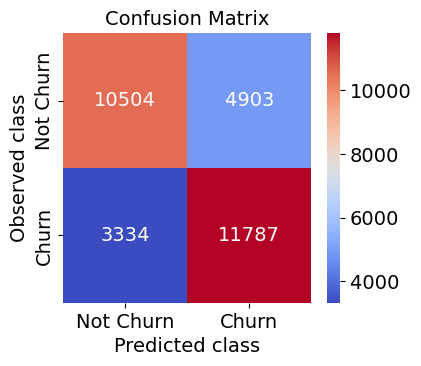

In [297]:
plt.figure(figsize=(4, 3.5))
ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='coolwarm')
ax.set_title('Confusion Matrix', fontsize=FONT_SIZE)
ax.set_xticklabels(['Not Churn', 'Churn'], fontsize=14)
ax.set_yticklabels(['Not Churn', 'Churn'], fontsize=14)
ax.set_xlabel('Predicted class', fontsize=14)
ax.set_ylabel('Observed class', fontsize=14)
plt.show()

<Figure size 300x300 with 0 Axes>

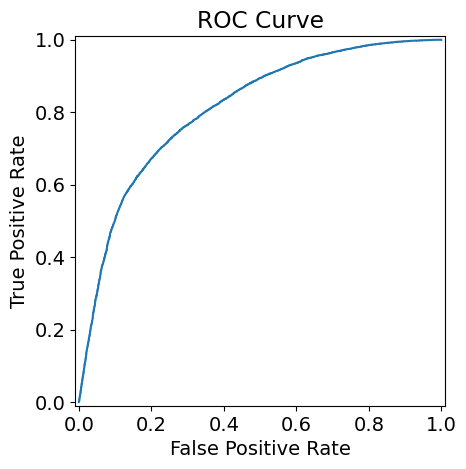

In [306]:
# Plot the ROC curve
plt.figure(figsize=(3, 3))
roc_display = RocCurveDisplay.from_estimator(best_model, X_test, y_test, pos_label=None)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
roc_display.ax_.legend_.remove()
plt.show()

### 4. Perform time series cross validation for all the available dates range

In [270]:
# helper function to obtain the indices of the train and test data
def generate_indices_by_date(df, start_date):
    current_train_date = pd.to_datetime(start_date)
    current_test_date = pd.to_datetime(start_date) + DateOffset(months=12)
    while True:
        next_train_date = current_train_date + DateOffset(months=1)
        next_test_date = current_train_date + DateOffset(months=13)
        indices_train_current = df[df['analysis_date'] == current_train_date.strftime('%Y-%m-%d')].index
        indices_test_current = df[df['analysis_date'] == current_test_date.strftime('%Y-%m-%d')].index
        
        if not indices_train_current.empty and not indices_test_current.empty:
            yield (current_train_date, current_test_date, indices_train_current, indices_test_current)
        else:
            return
        current_train_date = next_train_date
        current_test_date = next_test_date

In [271]:
# intiailize the generator
generator = generate_indices_by_date(df_churn_dataset, '2021-01-01')

In [272]:
time_series_cv_metrics = []

for data in generator:

    print(f"Training on {data[0]} and testing on {data[1]}")

    train_date = data[0]
    test_date = data[1]

    train_data = df_churn_dataset.iloc[data[2]]

    X_train = train_data.drop(columns=['is_churn', 'customer_id', 'analysis_date'])
    y_train = train_data['is_churn']

    #test_date = df_customer_value_dataset.iloc[data[1]]

    test_data = df_churn_dataset.iloc[data[3]]

    X_test = test_data.drop(columns=['is_churn', 'customer_id', 'analysis_date'])
    y_test = test_data['is_churn']

    best_model.fit(X_train, y_train)

    # Get the predicted probabilities for the positive class (is_churn = 1)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    # Calculate the AUC and Accuracy
    auc = np.round(roc_auc_score(y_test, y_prob), 3)

    accuracy = np.round(accuracy_score(y_test, y_pred), 3)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Extract values from the confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate the false positive rate
    false_positive_rate = fp / (fp + tn)

    # Calculate the false negative rate
    false_negative_rate = fn / (fn + tp)

    # Calculate the true positive rate
    true_positive_rate = tp / (tp + fn)

    # Calculate the true negative rate
    true_negative_rate = tn / (tn + fp)

    # Calculate the precision
    precision = tp / (tp + fp)

    # Calculate the recall
    recall = tp / (tp + fn)

    # Calculate the F1 score
    f1_score = 2 * (precision * recall) / (precision + recall)

    time_series_cv_metrics.append({'test_date': test_date,
                                   'auc': auc,
                                   'accuracy': accuracy,
                                   'false_positive_rate': np.round(false_positive_rate, 2),
                                   'false_negative_rate': np.round(false_negative_rate, 2),
                                   'true_positive_rate': np.round(true_positive_rate, 2),
                                   'true_negative_rate': np.round(true_negative_rate, 2),
                                   'precision': np.round(precision, 2),
                                   'recall': np.round(recall, 2),
                                   'f1_score': np.round(f1_score, 2)})


Training on 2021-01-01 00:00:00 and testing on 2022-01-01 00:00:00
Training on 2021-02-01 00:00:00 and testing on 2022-02-01 00:00:00
Training on 2021-03-01 00:00:00 and testing on 2022-03-01 00:00:00
Training on 2021-04-01 00:00:00 and testing on 2022-04-01 00:00:00
Training on 2021-05-01 00:00:00 and testing on 2022-05-01 00:00:00
Training on 2021-06-01 00:00:00 and testing on 2022-06-01 00:00:00
Training on 2021-07-01 00:00:00 and testing on 2022-07-01 00:00:00
Training on 2021-08-01 00:00:00 and testing on 2022-08-01 00:00:00
Training on 2021-09-01 00:00:00 and testing on 2022-09-01 00:00:00
Training on 2021-10-01 00:00:00 and testing on 2022-10-01 00:00:00
Training on 2021-11-01 00:00:00 and testing on 2022-11-01 00:00:00
Training on 2021-12-01 00:00:00 and testing on 2022-12-01 00:00:00
Training on 2022-01-01 00:00:00 and testing on 2023-01-01 00:00:00


In [273]:
df_time_series_cv_metrics = pd.DataFrame(time_series_cv_metrics).melt(id_vars=['test_date'],
                                                                      value_vars=['auc', 'accuracy', 'false_positive_rate',
                                                                                  'false_negative_rate', 'true_positive_rate',
                                                                                  'true_negative_rate', 'precision', 'recall', 'f1_score'],
                                                                                  var_name='metric_name',
                                                                                  value_name='metric_value').reset_index()

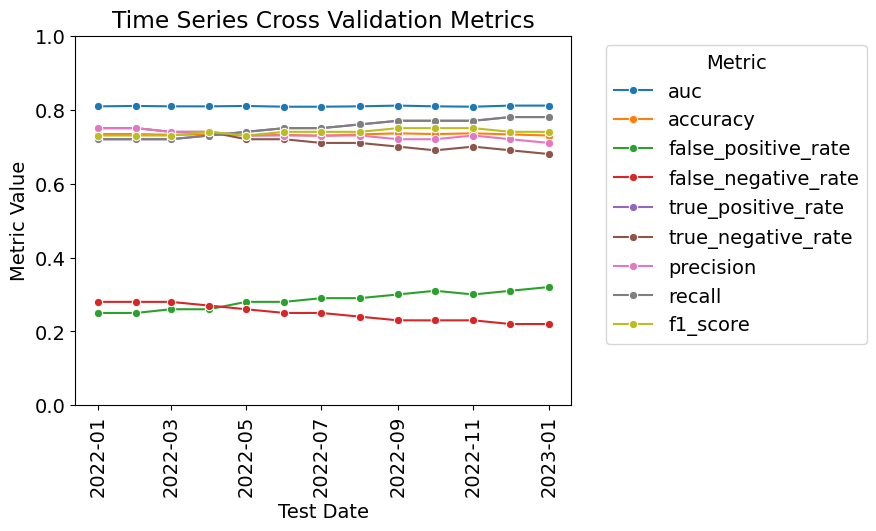

In [277]:
sns.lineplot(data=df_time_series_cv_metrics, x='test_date', y='metric_value', hue='metric_name', marker='o')
plt.title('Time Series Cross Validation Metrics')
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.ylabel('Metric Value', fontsize = FONT_SIZE)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Test Date', fontsize = FONT_SIZE)
plt.show()

### 5. Perform visual validation of the predictions

In [278]:
train_data = df_churn_dataset[df_churn_dataset['analysis_date'] == '2022-01-01'].copy()
test_data = df_churn_dataset[df_churn_dataset['analysis_date'] == '2023-01-01'].copy()


X_train = train_data.drop(columns=['is_churn', 'customer_id', 'analysis_date'])
y_train = train_data['is_churn']

X_test = test_data.drop(columns=['is_churn', 'customer_id', 'analysis_date'])
y_ttest = test_data['is_churn']

best_model.fit(X_train, y_train)

y_pred_validation = best_model.predict(X_test)

test_data['prediction'] = y_pred_validation

### 5.1. Validate predictions by recency class

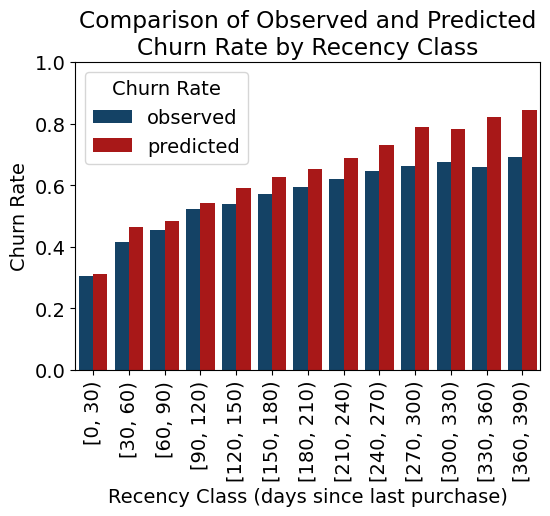

In [314]:
df_recency = test_data.copy()

df_recency['recency_class'] = pd.cut(df_recency['recency'], bins=range(0, df_recency['recency'].max() + 30, 30), right=False)

df_recency_grouped = df_recency.groupby('recency_class').\
    agg(observed = ('is_churn','mean'),
        predicted = ('prediction', 'mean')).\
        reset_index().\
        melt(id_vars='recency_class')

# Create a seaborn bar plot
plt.figure(figsize=(6, 4))
sns.barplot(data=df_recency_grouped, x='recency_class', y='value', hue='variable', palette=[PALLETTE['blue'], PALLETTE['red']])

# Add labels and title
plt.xlabel('Recency Class (days since last purchase)', fontsize=FONT_SIZE)
plt.xticks(rotation=90)
plt.ylabel('Churn Rate', fontsize=FONT_SIZE)
plt.ylim(0, 1)
plt.title('Comparison of Observed and Predicted\nChurn Rate by Recency Class')
plt.legend(title='Churn Rate')

# Show the plot
plt.show()

### 5.2. Validate predictions by frequency class

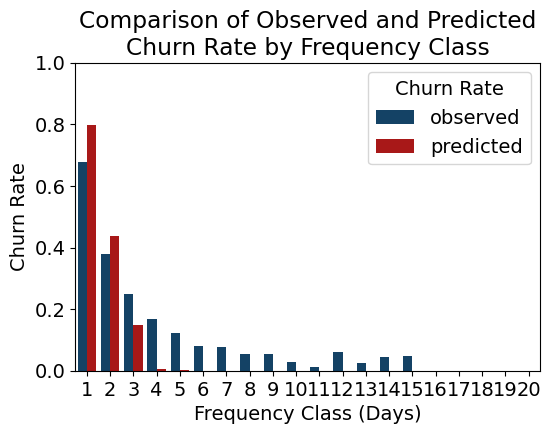

In [315]:
df_frequency = test_data[test_data['purchase_frequency_1_yr'] <= 20].copy()

df_frequency_grouped = df_frequency.groupby('purchase_frequency_1_yr').\
    agg(observed = ('is_churn','mean'),
        predicted = ('prediction', 'mean')).\
        reset_index().\
        melt(id_vars='purchase_frequency_1_yr')

# Create a seaborn bar plot
plt.figure(figsize=(6, 4))
sns.barplot(data=df_frequency_grouped, x='purchase_frequency_1_yr', y='value', hue='variable', palette=[PALLETTE['blue'], PALLETTE['red']])

# Add labels and title
plt.xlabel('Frequency Class (Days)', fontsize=FONT_SIZE)
plt.xticks(rotation=0)
plt.ylabel('Churn Rate', fontsize=FONT_SIZE)
plt.ylim(0, 1)
plt.title('Comparison of Observed and Predicted\nChurn Rate by Frequency Class')
plt.legend(title='Churn Rate')

# Show the plot
plt.show()

### 5.3. Validate predictions by purchase amount class

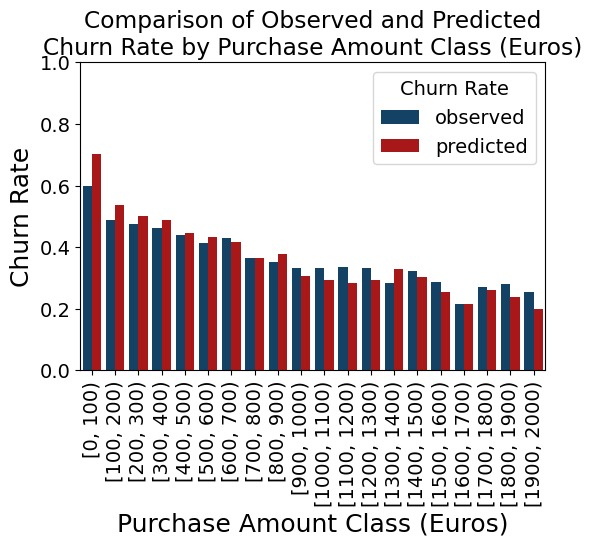

In [317]:
df_purchase_amount = test_data[test_data['purchase_amount_1_yr'] <= 2000].copy()

df_purchase_amount['purchase_amount_class'] = pd.cut(df_purchase_amount['purchase_amount_1_yr'], bins=range(0, df_purchase_amount['purchase_amount_1_yr'].astype('int').max() + 100, 100), right=False)

df_purchase_amount_grouped = df_purchase_amount.groupby('purchase_amount_class').\
    agg(observed = ('is_churn','mean'),
        predicted = ('prediction', 'mean')).\
        reset_index().\
        melt(id_vars='purchase_amount_class')

# Create a seaborn bar plot
plt.figure(figsize=(6, 4))
sns.barplot(data=df_purchase_amount_grouped, x='purchase_amount_class', y='value', hue='variable', palette=[PALLETTE['blue'], PALLETTE['red']])

# Add labels and title
plt.xlabel('Purchase Amount Class (Euros)', fontsize=FONT_SIZE_2)
plt.xticks(rotation=90)
plt.ylabel('Churn Rate', fontsize=FONT_SIZE_2)
plt.ylim(0, 1)
plt.title('Comparison of Observed and Predicted\nChurn Rate by Purchase Amount Class (Euros)')
plt.legend(title='Churn Rate')

# Show the plot
plt.show()

### 5.4. Validate predictions by tenure class

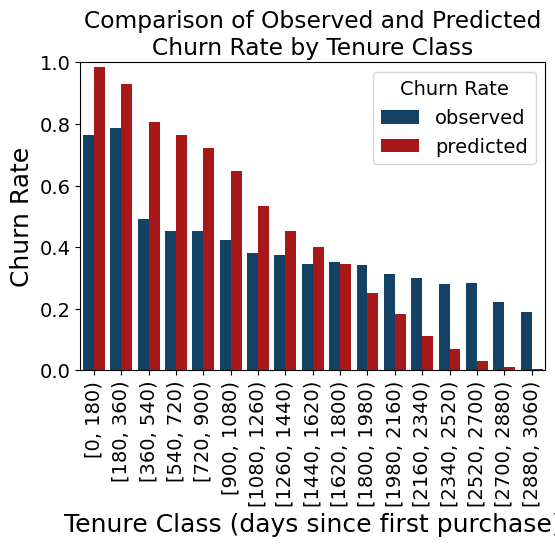

In [318]:
df_tenure = test_data.copy()

df_tenure['tenure_class'] = pd.cut(df_tenure['tenure'], bins=range(0, df_tenure['tenure'].max() + 180, 180), right=False)

df_tenure_grouped = df_tenure.groupby('tenure_class').\
    agg(observed = ('is_churn','mean'),
        predicted = ('prediction', 'mean')).\
        reset_index().\
        melt(id_vars='tenure_class')

# Create a seaborn bar plot
plt.figure(figsize=(6, 4))
sns.barplot(data=df_tenure_grouped, x='tenure_class', y='value', hue='variable', palette=[PALLETTE['blue'], PALLETTE['red']])

# Add labels and title
plt.xlabel('Tenure Class (days since first purchase)', fontsize=FONT_SIZE_2)
plt.xticks(rotation=90)
plt.ylabel('Churn Rate', fontsize=FONT_SIZE_2)
plt.ylim(0, 1)
plt.title('Comparison of Observed and Predicted\nChurn Rate by Tenure Class')
plt.legend(title='Churn Rate')

# Show the plot
plt.show()

### 5.5. Validate predictions by total purchase amount class

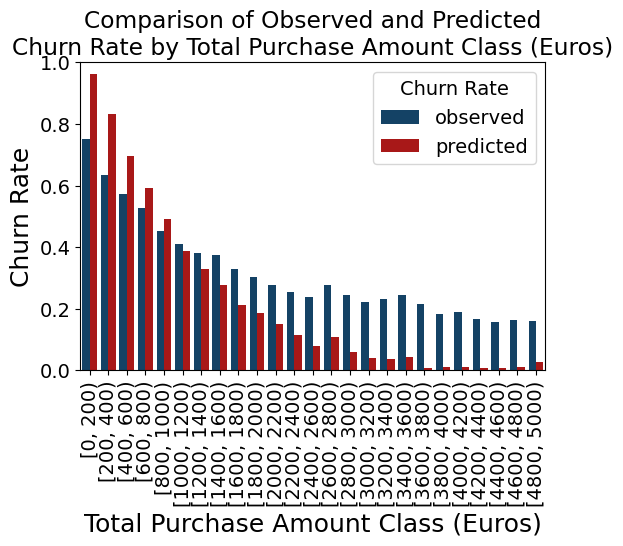

In [319]:
df_total_purchase_amount = test_data[test_data['total_purchase_amount'] <= 5000].copy()

df_total_purchase_amount['total_purchase_amount_class'] = pd.cut(df_total_purchase_amount['total_purchase_amount'], bins=range(0, df_total_purchase_amount['total_purchase_amount'].astype('int').max() + 200, 200), right=False)

df_total_purchase_amount_grouped = df_total_purchase_amount.groupby('total_purchase_amount_class').\
    agg(observed = ('is_churn','mean'),
        predicted = ('prediction', 'mean')).\
        reset_index().\
        melt(id_vars='total_purchase_amount_class')

# Create a seaborn bar plot
plt.figure(figsize=(6, 4))
sns.barplot(data=df_total_purchase_amount_grouped, x='total_purchase_amount_class', y='value', hue='variable', palette=[PALLETTE['blue'], PALLETTE['red']])

# Add labels and title
plt.xlabel('Total Purchase Amount Class (Euros)', fontsize=FONT_SIZE_2)
plt.xticks(rotation=90)
plt.ylabel('Churn Rate', fontsize=FONT_SIZE_2)
plt.ylim(0, 1)
plt.title('Comparison of Observed and Predicted\nChurn Rate by Total Purchase Amount Class (Euros)')
plt.legend(title='Churn Rate')

# Show the plot
plt.show()

### 5.6. Validate predictions by returns frequency amount class

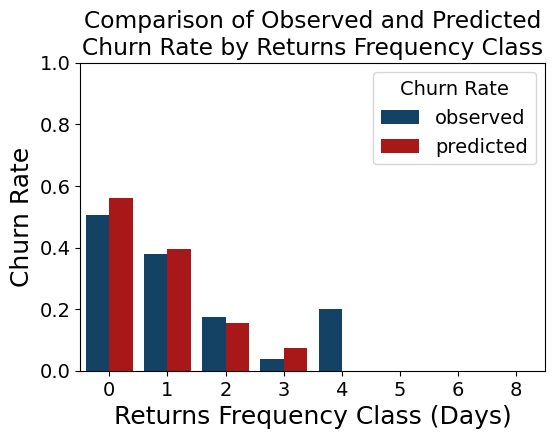

In [320]:
df_returns_frequency = test_data[test_data['returns_frequency_1_yr'] <= 20].copy()

df_returns_frequency_grouped = df_returns_frequency.groupby('returns_frequency_1_yr').\
    agg(observed = ('is_churn','mean'),
        predicted = ('prediction', 'mean')).\
        reset_index().\
        melt(id_vars='returns_frequency_1_yr')

# Create a seaborn bar plot
plt.figure(figsize=(6, 4))
sns.barplot(data=df_returns_frequency_grouped, x='returns_frequency_1_yr', y='value', hue='variable', palette=[PALLETTE['blue'], PALLETTE['red']])

# Add labels and title
plt.xlabel('Returns Frequency Class (Days)', fontsize=FONT_SIZE_2)
plt.xticks(rotation=0)
plt.ylabel('Churn Rate', fontsize=FONT_SIZE_2)
plt.ylim(0, 1)
plt.title('Comparison of Observed and Predicted\nChurn Rate by Returns Frequency Class')
plt.legend(title='Churn Rate')

# Show the plot
plt.show()

### 5.7. Validate predictions by returned amount class

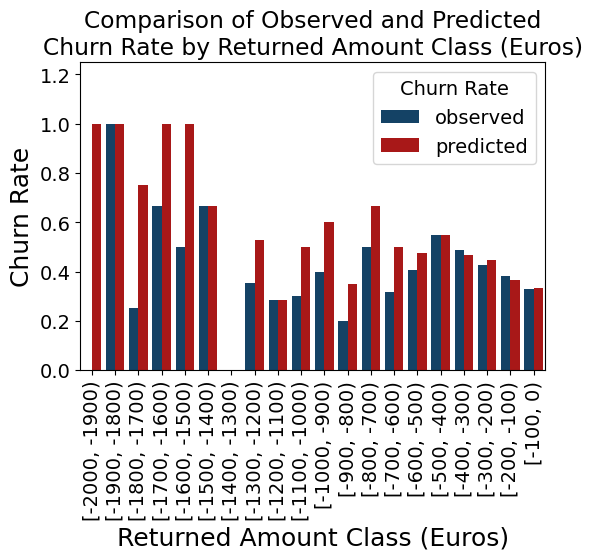

In [322]:
df_returned_amount = test_data[test_data['returned_amount_1_yr'] >= -2000].copy()

df_returned_amount['returned_amount_class'] = pd.cut(df_returned_amount['returned_amount_1_yr'], bins=range(-2000, df_returned_amount['returned_amount_1_yr'].astype('int').max() + 100, 100), right=False)

df_returned_amount_grouped = df_returned_amount.groupby('returned_amount_class').\
    agg(observed = ('is_churn','mean'),
        predicted = ('prediction', 'mean')).\
        reset_index().\
        melt(id_vars='returned_amount_class')

# Create a seaborn bar plot
plt.figure(figsize=(6, 4))
sns.barplot(data=df_returned_amount_grouped, x='returned_amount_class', y='value', hue='variable', palette=[PALLETTE['blue'], PALLETTE['red']])

# Add labels and title
plt.xlabel('Returned Amount Class (Euros)', fontsize=FONT_SIZE_2)
plt.xticks(rotation=90)
plt.ylabel('Churn Rate', fontsize=FONT_SIZE_2)
plt.ylim(0, 1.25)
plt.title('Comparison of Observed and Predicted\nChurn Rate by Returned Amount Class (Euros)')
plt.legend(title='Churn Rate')

# Show the plot
plt.show()